In [34]:
'''TO DO:

Currently running on Keras Fashion Mnist data with ~90% validation set accuracy using a 1 layer convnet
have yet to add bias term and pooling function to backprop
'''


import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from itertools import repeat
import keras

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
#select 2 of the classes for analysis
cond=np.any([y_train_full==1,y_train_full==3],0)
X_train_full=X_train_full[cond]
y_train_full=y_train_full[cond]
X_test=X_test[np.any([y_test==1,y_test==3],0)]
y_test=y_test[np.any([y_test==1,y_test==3],0)]
y_train_full=(y_train_full==3).astype(int)
y_test=(y_test==3).astype(int)

#Holdout Validation Set
X_train, X_valid = X_train_full[:-1000], X_train_full[-1000:]
y_train, y_valid = y_train_full[:-1000], y_train_full[-1000:]
#Scaling - note that the mean and standard deviation are used to standardise the validation and test sets as well
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
# X_test = (X_test - X_mean) / X_std

# Vectorised convolution operation runtime is 0.03seconds on 28 by 28 grey scale image and 3 by 3 kernel
# Tested approximately 2 times slower than Scipy.convolve
def convolution(image_array,filter):
    filter_size=filter.shape[1]
    r=image_array.shape[0]
    c=image_array.shape[1]
    new_image_array=np.uint16(image_array)
    reduced=new_image_array[np.uint16(filter_size/2):r-np.uint16(filter_size/2),np.uint16(filter_size/2):c-np.uint16(filter_size/2)]
    reduced_indices=np.argwhere(reduced==0|reduced)
    reduced_I=reduced_indices[:,0]
    reduced_J=reduced_indices[:,1]
    combined_reduced_indices=reduced_I*c+reduced_J

    original_I=reduced_I+np.uint16(filter_size/2)
    original_J=reduced_J+np.uint16(filter_size/2)
    combined_original_indices=original_I*c+original_J

    adjustor_I=np.array(np.repeat(range(-1*np.uint16(filter_size/2),np.uint16(filter_size/2)+1),filter_size))
    adjustor_J=np.tile(np.array(range(-1*np.uint16(filter_size/2),np.uint16(filter_size/2)+1)),filter_size)
    combined_adjustor_indices=adjustor_I*c+adjustor_J

    flattened=image_array.flatten()
    tiled_indices=np.reshape(np.tile(combined_original_indices,filter_size*filter_size),(filter_size*filter_size,len(combined_original_indices)))

    flattened_indices=combined_adjustor_indices.reshape(filter_size*filter_size,1)+tiled_indices
    flattened_image=flattened[flattened_indices]

    split_array= np.split(flattened_image,filter_size*filter_size)

    flattened_image=np.stack(split_array,axis=-1)


    image_matrix=flattened_image.reshape(r-np.uint16(filter_size-1),c-np.uint16(filter_size-1),filter_size,filter_size)
    final=filter*image_matrix
    result=np.sum(np.sum(final,axis=2),axis=2)
    #plt.imshow(absolute_final)
    return result,image_matrix

def relu(feature_map):
    x=feature_map.copy()
    #Preparing the output of the ReLU activation function.
    return np.maximum(x,0,x)



def sigmoid(x):
    return 1/(1+np.exp(-1*x))


def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b


''' __________________Discalimer_______________: Credit for pooling function to Stackoverflow user "Jason" 
https://stackoverflow.com/questions/42463172/how-to-perform-max-mean-pooling-on-a-2d-array-using-numpy'''
def pooling(mat,ksize,method='max',pad=False):
    '''Non-overlapping pooling on 2D or 3D data.

    <mat>: ndarray, input array to pool.
    <ksize>: tuple of 2, kernel size in (ky, kx).
    <method>: str, 'max for max-pooling, 
                   'mean' for mean-pooling.
    <pad>: bool, pad <mat> or not. If no pad, output has size
           n//f, n being <mat> size, f being kernel size.
           if pad, output has size ceil(n/f).

    Return <result>: pooled matrix.
    '''

    m, n = mat.shape[:2]
    ky,kx=ksize

    _ceil=lambda x,y: int(np.ceil(x/float(y)))

    if pad:
        ny=_ceil(m,ky)
        nx=_ceil(n,kx)
        size=(ny*ky, nx*kx)+mat.shape[2:]
        mat_pad=numpy.full(size,np.nan)
        mat_pad[:m,:n,...]=mat
    else:
        ny=m//ky
        nx=n//kx
        mat_pad=mat[:ny*ky, :nx*kx, ...]

    new_shape=(ny,ky,nx,kx)+mat.shape[2:]

    if method=='max':
        result=np.nanmax(mat_pad.reshape(new_shape),axis=(1,3))
    else:
        result=np.nanmean(mat_pad.reshape(new_shape),axis=(1,3))

    return result




training set accuracy: 89.27%


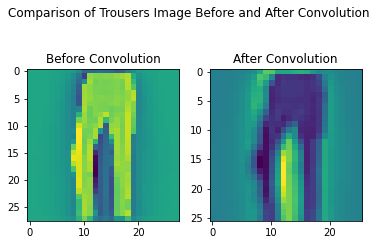

In [39]:


#_____________________________________________________Initialise weight matrices_________________________________________________________
# W1 is convolutional layer (currently 1 filter), W2 is densely connected layer.
np.random.seed(0)
scaling_parameter=1
W1=np.random.rand(3,3)/scaling_parameter  #need to scale weights to avoid vanishing gradients
filter_size=3
dense_layer_weight_size=X_train.shape[1]-int((filter_size+1)/2)
W2=np.random.rand(dense_layer_weight_size,dense_layer_weight_size)
# It seems that scaling down convolutional weights by 10,000 whilst leaving the densely connected weight to be small numbers between 0 and 1
# leads to good results.
W2_flattened=W2.flatten()


train_array_loss=[]
train_array_accuracy=[]
val_loss_array=[]
X_train_shuffled,y_train_shuffled=shuffle_in_unison(X_train,y_train)
X_valid_shuffled,y_valid_shuffled=shuffle_in_unison(X_valid,y_valid)
accuracy=[]
# ________________________________________________________________TRAINING THE NETWORK - SGD_________________________________________________
n=10000#len(y_train) number of iterations to train
for i in range(n):

  # print("iteration :",str(i+1)+"/"+str(n))
  # selects different image every time
    X=X_train_shuffled[i]
    Y=y_train_shuffled[i]


    convoluted_1,image_matrix=convolution(X,W1)

    relu_1_flattened=relu(convoluted_1.reshape(26*26))


  #W2 flattened is  updating

    activated=sigmoid(np.dot(relu_1_flattened,W2_flattened))
    activated=activated.clip(10**-16,1-10**-16)

    loss_function= -Y*np.log(activated)-(1-Y)*np.log(1-activated)



    dL_dz=(activated*(1-Y)-(1-activated)*Y)/(activated*(1-activated))

    '''gradient checking'''
    # dL/dz correct
    # dz_dn2 correct
    # dz_dW2 correct
    # epsilon=10e-10 
    # loss_function_plus=-Y*np.log(activated+epsilon)-(1-Y)*np.log(1-activated-epsilon)
    # loss_function_minus=-Y*np.log(activated-epsilon)-(1-Y)*np.log(1-activated+epsilon)
    # gradient_check=(loss_function_plus-loss_function_minus)/(2*epsilon)
    # print(dL_dz,gradient_check,"difference:",gradient_check-dL_dz)
    dz_dW2=((1-Y)*activated-Y*(1-activated))*relu_1_flattened
    dz_dn2=activated*(1-activated)*W2_flattened.reshape(26,26)


    image_matrix_reshaped=image_matrix.reshape(3,3,26,26)
    dn2_dw1=image_matrix_reshaped*(convoluted_1>0) #to be checked <<<--------------think its correct
    
    dz_dW1=dn2_dw1*dz_dn2

    dL_dW1=dL_dz*(np.sum(np.sum(dz_dW1,axis=2),axis=2))

    #layer 2 gradients
    dL_dW2=dL_dz*(activated*(1-activated))*relu_1_flattened
    #simultaneous weight updates

    learning_rate=0.001
    W1=W1-learning_rate*dL_dW1

    W2_flattened=W2_flattened-learning_rate*dL_dW2


    train_array_accuracy.append(int(activated>0.5)==Y)
    train_array_loss.append(loss_function)


print("training set accuracy:",str(sum(train_array_accuracy)*100/len(train_array_accuracy))+"%")
# print(train_array_loss)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Comparison of Trousers Image Before and After Convolution')
ax1.imshow(X)
ax1.title.set_text('Before Convolution')

ax2.imshow(convoluted_1)
ax2.title.set_text('After Convolution')



validation set accuracy 91.2%


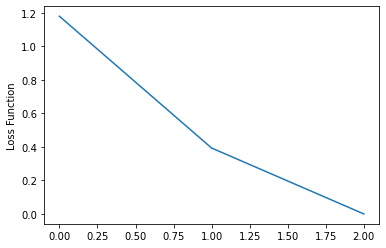

final train loss: 1.3580785527020915 
minimum train loss: 1.3580785527020915
final valid loss: 0.0 
minimum valid loss: 0.0


In [13]:


#important in plotting curve that loss function is calculated before parameter update
# _______________________________________________________Evaluate trained network on Validation Set______________________________________________
# want to evaluate synchronously with training - could expand dimension in convolution operation
predicted_array=[]

val_loss_sum=0
m=len(X_valid)
for j in range(m):
    X_val=X_valid_shuffled[j]
    Y_val=y_valid_shuffled[j]
    convoluted_1_valid,image_matrix_valid=convolution(X_val,W1)
    relu_1_flattened_valid=relu(convoluted_1_valid.reshape(26*26)) 
    val_activated=sigmoid(np.dot(relu_1_flattened_valid,W2_flattened))
    val_activated=val_activated.clip(10**-16,1-10**-16)

    val_loss_function= -Y_val*np.log(val_activated)-(1-Y_val)*np.log(1-val_activated)



    predicted_array.append(int(val_activated>0.5)==Y_val)
    val_loss_sum+=val_loss_function
    avg_val_loss=val_loss_sum/m
    val_loss_array.append(avg_val_loss)

val_accuracy=(np.sum(predicted_array)/m)



print("validation set accuracy:",str(val_accuracy*100)+"%")



def smoothed_convergence_curve(train_loss,valid_loss,sliding_window):
  # choose sliding window to smooth noisy loss curve
    cumulative_array_train_loss=[]
    cumulative_array_valid_loss=[]   
    for i in range(int(len(train_loss)/sliding_window)):
        cumulative_array_train_loss.append(sum(train_loss[sliding_window*i:(i+1)*sliding_window])/sliding_window)
        cumulative_array_valid_loss.append(sum(valid_loss[sliding_window*i:(i+1)*sliding_window])/sliding_window)
    # plt.plot(range(len(cumulative_array_train_loss)),cumulative_array_train_loss)
    plt.plot(range(len(cumulative_array_valid_loss)),cumulative_array_valid_loss)
    plt.ylabel("Loss Function")
    plt.show()
    print("final train loss:",cumulative_array_train_loss[-1],"\nminimum train loss:",min(cumulative_array_train_loss))
    print("final valid loss:",cumulative_array_valid_loss[-1],"\nminimum valid loss:",min(cumulative_array_valid_loss))
    

smoothed_convergence_curve(train_array_loss,val_loss_array,3000)

# Will be used when validating after every weight update in training the network
# def accuracy_curve(accuracy_array):
#   plt.plot(range(len(accuracy_array)),accuracy_array)
# accuracy_curve(predicted_array)